In [27]:
# https://catboost.ai/docs/en/concepts/python-reference_catboostclassifier

In [1]:
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import joblib
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
model_filename = "../../corrected_baseline.joblib"#"../../model.joblib"
model = joblib.load(model_filename)


In [3]:
len(model.feature_names_)

94

In [42]:
feature_importance = model.feature_importances_
selected_feature_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 18, 20, 22, 24, 29, 32, 34, 42, 50, 52, 60, 63, 64, 65, 70, 71, 72, 73, 74, 75, 76, 77, 85, 89, 90, 93]
string_selected_list = [str(s) for s in selected_feature_names]
feature_names = model.feature_names_
data = {'feature_names':feature_names,'feature_importance':feature_importance}
impt_df = pd.DataFrame(data)

In [43]:
impt_df.reset_index()

,index,feature_names,feature_importance
0,0,0,4.515856
1,1,1,0.811960
2,2,2,1.482546
3,3,3,0.545977
4,4,4,3.143033
...,...,...,...
89,89,89,1.192107
90,90,90,3.098776
91,91,91,0.234850
92,92,92,0.512581


In [44]:
def build_lookup_list(start, end):
    range_list = [*range(start,(end+1),1)]
    range_list = [str(s) for s in range_list]
    return range_list

In [45]:
dem_feat = 0
s1_feat = ['1', '2']
s2_feat = build_lookup_list(3, 12)
TTC_feat = build_lookup_list(13, 77)
tex_blue_feat = build_lookup_list(78, 81)
tex_green_feat = build_lookup_list(82, 85)
tex_red_feat = build_lookup_list(86, 89)
tex_nir_feat = build_lookup_list(90, 93)

In [46]:
impt_df['category'] = 'na'
impt_df.loc[impt_df['feature_names'] == '0', 'category'] = 'DEM'
impt_df.loc[np.isin(impt_df['feature_names'], s1_feat), 'category'] = 'Sentinel 1'
impt_df.loc[np.isin(impt_df['feature_names'], s2_feat), 'category'] = 'Sentinel 2'
impt_df.loc[np.isin(impt_df['feature_names'], TTC_feat), 'category'] = 'TTC'
impt_df.loc[np.isin(impt_df['feature_names'], tex_blue_feat), 'category'] = 'Texture (blue band)'
impt_df.loc[np.isin(impt_df['feature_names'], tex_green_feat), 'category'] = 'Texture (green band)'
impt_df.loc[np.isin(impt_df['feature_names'], tex_red_feat), 'category'] = 'Texture (red band)'
impt_df.loc[np.isin(impt_df['feature_names'], tex_nir_feat), 'category'] = 'Texture (NIR band)'

In [47]:
impt_df['selected'] = False
impt_df.loc[np.isin(impt_df['feature_names'], string_selected_list), 'selected'] = True


In [48]:
impt_df

,feature_names,feature_importance,category,selected
0,0,4.515856,DEM,True
1,1,0.811960,Sentinel 1,True
2,2,1.482546,Sentinel 1,True
3,3,0.545977,Sentinel 2,True
4,4,3.143033,Sentinel 2,True
...,...,...,...,...
89,89,1.192107,Texture (red band),True
90,90,3.098776,Texture (NIR band),True
91,91,0.234850,Texture (NIR band),False
92,92,0.512581,Texture (NIR band),False


In [33]:
impt_df.sort_values(['category', 'feature_importance'], ascending=False, inplace=True)
impt_df = impt_df.astype({"feature_importance":float, "feature_names": str})

<Axes: xlabel='feature_importance', ylabel='feature_names'>

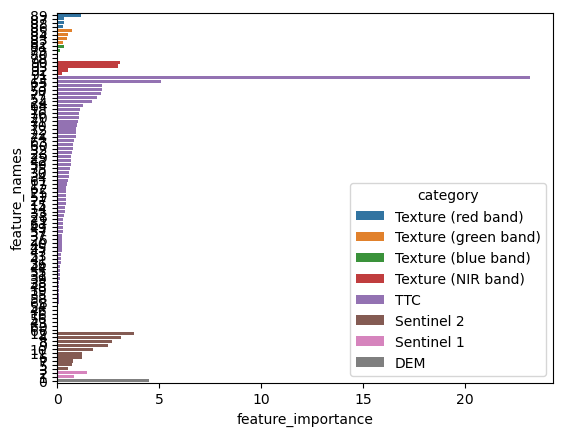

In [34]:
sns.barplot(data=impt_df, y = 'feature_names', x='feature_importance', hue='category')

<Axes: xlabel='feature_importance', ylabel='category'>

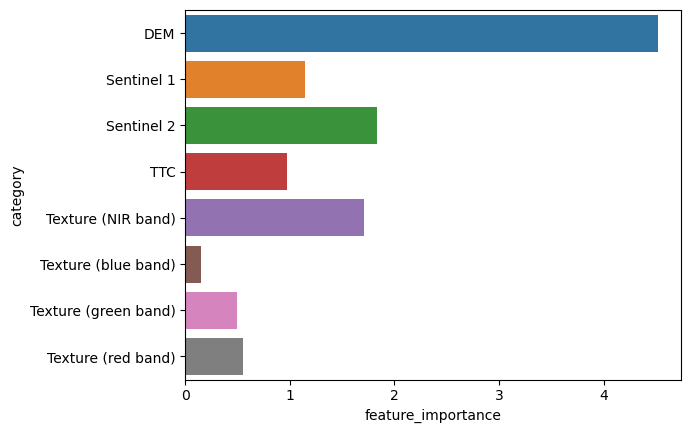

In [63]:
mean_importance = pd.DataFrame(impt_df.groupby('category')['feature_importance'].mean()).reset_index()
mean_importance
sns.barplot(data=mean_importance, y = 'category', x='feature_importance', hue='category')

In [54]:
total_counts = impt_df.groupby('category')['feature_importance'].count()
total_counts

category
DEM                      1
Sentinel 1               2
Sentinel 2              10
TTC                     65
Texture (NIR band)       4
Texture (blue band)      4
Texture (green band)     4
Texture (red band)       4
Name: feature_importance, dtype: int64

In [55]:
selected_counts = impt_df[impt_df['selected'] == True].groupby('category')['feature_importance'].count()
selected_counts

category
DEM                      1
Sentinel 1               2
Sentinel 2              10
TTC                     23
Texture (NIR band)       2
Texture (green band)     1
Texture (red band)       1
Name: feature_importance, dtype: int64

In [70]:
percent_selected = pd.DataFrame((selected_counts / total_counts) * 100).reset_index()
percent_selected['percent_selected'] = percent_selected['feature_importance'].fillna(0)
percent_selected

,category,feature_importance,percent_selected
0,DEM,100.000000,100.000000
1,Sentinel 1,100.000000,100.000000
2,Sentinel 2,100.000000,100.000000
3,TTC,35.384615,35.384615
4,Texture (NIR band),50.000000,50.000000
5,Texture (blue band),NaN,0.000000
6,Texture (green band),25.000000,25.000000
7,Texture (red band),25.000000,25.000000


<Axes: xlabel='percent_selected', ylabel='category'>

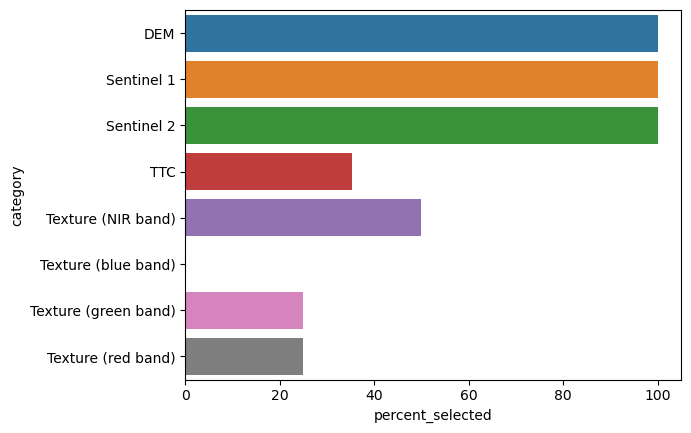

In [71]:
sns.barplot(data=percent_selected, y = 'category', x='percent_selected', hue='category')